## Import

In [1]:
!pip install pycaret
!pip install numpy

!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: sklearn 0.0.post1
Uninstalling sklearn-0.0.post1:
  Successfully uninstalled sklearn-0.0.post1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sklearn-0.0.post1-py3-none-any.whl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sklearn
sklearn.__version__

'0.23.2'

In [3]:
from pycaret.utils import enable_colab

enable_colab()

Colab mode enabled.


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import random
import os
import numpy as np

from pycaret.classification import *
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(777) # Seed 고정

### train.csv [파일]
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target) 
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)
- Y_Quality : 제품 품질 관련 정량적 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


### test.csv [파일]
- PRODUCT_ID : 제품의 고유 ID
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


### sample_submission.csv [파일] - 제출 양식
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 예측한 제품 품질 상태
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)

실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.

## Data Load

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/datasets/aimers/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/datasets/aimers/test.csv')

In [8]:
train_df.index = pd.to_datetime(train_df["TIMESTAMP"])
test_df.index = pd.to_datetime(test_df["TIMESTAMP"])

train_df.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_57,X_58,X_59,X_60,X_61,X_62,X_63,X_64,X_65,X_66,X_67,X_68,X_69,X_70,X_71,X_72,X_73,X_74,X_75,X_76,X_77,X_78,X_79,X_80,X_81,X_82,X_83,X_84,X_85,X_86,X_87,X_88,X_89,X_90,X_91,X_92,X_93,X_94,X_95,X_96,X_97,X_98,X_99,X_100,X_101,X_102,X_103,X_104,X_105,X_106,X_107,X_108,X_109,X_110,X_111,X_112,X_113,X_114,X_115,X_116,X_117,X_118,X_119,X_120,X_121,X_122,X_123,X_124,X_125,X_126,X_127,X_128,X_129,X_130,X_131,X_132,X_133,X_134,X_135,X_136,X_137,X_138,X_139,X_140,X_141,X_142,X_143,X_144,X_145,X_146,X_147,X_148,X_149,X_150,X_151,X_152,X_153,X_154,X_155,X_156,X_157,X_158,X_159,X_160,X_161,X_162,X_163,X_164,X_165,X_166,X_167,X_168,X_169,X_170,X_171,X_172,X_173,X_174,X_175,X_176,X_177,X_178,X_179,X_180,X_181,X_182,X_183,X_184,X_185,X_186,X_187,X_188,X_189,X_190,X_191,X_192,X_193,X_194,X_195,X_196,X_197,X_198,X_199,X_200,X_201,X_202,X_203,X_204,X_205,X_206,X_207,X_208,X_209,X_210,X_211,X_212,X_213,X_214,X_215,X_216,X_217,X_218,X_219,X_220,X_221,X_222,X_223,X_224,X_225,X_226,X_227,X_228,X_229,X_230,X_231,X_232,X_233,X_234,X_235,X_236,X_237,X_238,X_239,X_240,X_241,X_242,X_243,X_244,...,X_2626,X_2627,X_2628,X_2629,X_2630,X_2631,X_2632,X_2633,X_2634,X_2635,X_2636,X_2637,X_2638,X_2639,X_2640,X_2641,X_2642,X_2643,X_2644,X_2645,X_2646,X_2647,X_2648,X_2649,X_2650,X_2651,X_2652,X_2653,X_2654,X_2655,X_2656,X_2657,X_2658,X_2659,X_2660,X_2661,X_2662,X_2663,X_2664,X_2665,X_2666,X_2667,X_2668,X_2669,X_2670,X_2671,X_2672,X_2673,X_2674,X_2675,X_2676,X_2677,X_2678,X_2679,X_2680,X_2681,X_2682,X_2683,X_2684,X_2685,X_2686,X_2687,X_2688,X_2689,X_2690,X_2691,X_2692,X_2693,X_2694,X_2695,X_2696,X_2697,X_2698,X_2699,X_2700,X_2701,X_2702,X_2703,X_2704,X_2705,X_2706,X_2707,X_2708,X_2709,X_2710,X_2711,X_2712,X_2713,X_2714,X_2715,X_2716,X_2717,X_2718,X_2719,X_2720,X_2721,X_2722,X_2723,X_2724,X_2725,X_2726,X_2727,X_2728,X_2729,X_2730,X_2731,X_2732,X_2733,X_2734,X_2735,X_2736,X_2737,X_2738,X_2739,X_2740,X_2741,X_2742,X_2743,X_2744,X_2745,X_2746,X_2747,X_2748,X_2749,X_2750,X_2751,X_2752,X_2753,X_2754,X_2755,X_2756,X_2757,X_2758,X_2759,X_2760,X_2761,X_2762,X_2763,X_2764,X_2765,X_2766,X_2767,X_2768,X_2769,X_2770,X_2771,X_2772,X_2773,X_2774,X_2775,X_2776,X_2777,X_2778,X_2779,X_2780,X_2781,X_2782,X_2783,X_2784,X_2785,X_2786,X_2787,X_2788,X_2789,X_2790,X_2791,X_2792,X_2793,X_2794,X_2795,X_2796,X_2797,X_2798,X_2799,X_2800,X_2801,X_2802,X_2803,X_2804,X_2805,X_2806,X_2807,X_2808,X_2809,X_2810,X_2811,X_2812,X_2813,X_2814,X_2815,X_2816,X_2817,X_2818,X_2819,X_2820,X_2821,X_2822,X_2823,X_2824,X_2825,X_2826,X_2827,X_2828,X_2829,X_2830,X_2831,X_2832,X_2833,X_2834,X_2835,X_2836,X_2837,X_2838,X_2839,X_2840,X_2841,X_2842,X_2843,X_2844,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2851,X_2852,X_2853,X_2854,X_2855,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-13 05:14:00,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [9]:
del_list = []
for i in range(6, 2880):
    if train_df.iloc[:, i].nunique() == 0:
        del_list.append(train_df.columns[i])
        
print(del_list)

['X_934', 'X_935', 'X_936', 'X_937', 'X_2628', 'X_2629', 'X_2630', 'X_2631', 'X_2632', 'X_2633', 'X_2634', 'X_2635', 'X_2636', 'X_2637', 'X_2638', 'X_2639', 'X_2640', 'X_2641', 'X_2642', 'X_2643', 'X_2644', 'X_2645', 'X_2646', 'X_2647', 'X_2648', 'X_2649', 'X_2650', 'X_2651', 'X_2652', 'X_2653', 'X_2654', 'X_2655', 'X_2656', 'X_2657', 'X_2658', 'X_2659', 'X_2660', 'X_2661', 'X_2662', 'X_2663', 'X_2664', 'X_2665', 'X_2666', 'X_2667', 'X_2668', 'X_2669', 'X_2670', 'X_2671', 'X_2672', 'X_2673', 'X_2674', 'X_2675', 'X_2676', 'X_2677', 'X_2678', 'X_2679', 'X_2680', 'X_2681', 'X_2682', 'X_2683', 'X_2684', 'X_2685', 'X_2686', 'X_2687', 'X_2688', 'X_2689', 'X_2690', 'X_2691', 'X_2692', 'X_2693', 'X_2694', 'X_2695', 'X_2696', 'X_2697', 'X_2698', 'X_2699', 'X_2838', 'X_2844', 'X_2872', 'X_2873', 'X_2874']


In [10]:
train_df.drop(columns=del_list, inplace=True)
test_df.drop(columns=del_list, inplace=True)

In [25]:
train_df = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

test_df = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [26]:
train_df.head()

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_57,X_58,X_59,X_60,X_61,X_62,X_63,X_64,X_65,X_66,X_67,X_68,X_69,X_70,X_71,X_72,X_73,X_74,X_75,X_76,X_77,X_78,X_79,X_80,X_81,X_82,X_83,X_84,X_85,X_86,X_87,X_88,X_89,X_90,X_91,X_92,X_93,X_94,X_95,X_96,X_97,X_98,X_99,X_100,X_101,X_102,X_103,X_104,X_105,X_106,X_107,X_108,X_109,X_110,X_111,X_112,X_113,X_114,X_115,X_116,X_117,X_118,X_119,X_120,X_121,X_122,X_123,X_124,X_125,X_126,X_127,X_128,X_129,X_130,X_131,X_132,X_133,X_134,X_135,X_136,X_137,X_138,X_139,X_140,X_141,X_142,X_143,X_144,X_145,X_146,X_147,X_148,X_149,X_150,X_151,X_152,X_153,X_154,X_155,X_156,X_157,X_158,X_159,X_160,X_161,X_162,X_163,X_164,X_165,X_166,X_167,X_168,X_169,X_170,X_171,X_172,X_173,X_174,X_175,X_176,X_177,X_178,X_179,X_180,X_181,X_182,X_183,X_184,X_185,X_186,X_187,X_188,X_189,X_190,X_191,X_192,X_193,X_194,X_195,X_196,X_197,X_198,X_199,X_200,X_201,X_202,X_203,X_204,X_205,X_206,X_207,X_208,X_209,X_210,X_211,X_212,X_213,X_214,X_215,X_216,X_217,X_218,X_219,X_220,X_221,X_222,X_223,X_224,X_225,X_226,X_227,X_228,X_229,X_230,X_231,X_232,X_233,X_234,X_235,X_236,X_237,X_238,X_239,X_240,X_241,X_242,X_243,X_244,X_245,X_246,...,X_2549,X_2550,X_2551,X_2552,X_2553,X_2554,X_2555,X_2556,X_2557,X_2558,X_2559,X_2560,X_2561,X_2562,X_2563,X_2564,X_2565,X_2566,X_2567,X_2568,X_2569,X_2570,X_2571,X_2572,X_2573,X_2574,X_2575,X_2576,X_2577,X_2578,X_2579,X_2580,X_2581,X_2582,X_2583,X_2584,X_2585,X_2586,X_2587,X_2588,X_2589,X_2590,X_2591,X_2592,X_2593,X_2594,X_2595,X_2596,X_2597,X_2598,X_2599,X_2600,X_2601,X_2602,X_2603,X_2604,X_2605,X_2606,X_2607,X_2608,X_2609,X_2610,X_2611,X_2612,X_2613,X_2614,X_2615,X_2616,X_2617,X_2618,X_2619,X_2620,X_2621,X_2622,X_2623,X_2624,X_2625,X_2626,X_2627,X_2700,X_2701,X_2702,X_2703,X_2704,X_2705,X_2706,X_2707,X_2708,X_2709,X_2710,X_2711,X_2712,X_2713,X_2714,X_2715,X_2716,X_2717,X_2718,X_2719,X_2720,X_2721,X_2722,X_2723,X_2724,X_2725,X_2726,X_2727,X_2728,X_2729,X_2730,X_2731,X_2732,X_2733,X_2734,X_2735,X_2736,X_2737,X_2738,X_2739,X_2740,X_2741,X_2742,X_2743,X_2744,X_2745,X_2746,X_2747,X_2748,X_2749,X_2750,X_2751,X_2752,X_2753,X_2754,X_2755,X_2756,X_2757,X_2758,X_2759,X_2760,X_2761,X_2762,X_2763,X_2764,X_2765,X_2766,X_2767,X_2768,X_2769,X_2770,X_2771,X_2772,X_2773,X_2774,X_2775,X_2776,X_2777,X_2778,X_2779,X_2780,X_2781,X_2782,X_2783,X_2784,X_2785,X_2786,X_2787,X_2788,X_2789,X_2790,X_2791,X_2792,X_2793,X_2794,X_2795,X_2796,X_2797,X_2798,X_2799,X_2800,X_2801,X_2802,X_2803,X_2804,X_2805,X_2806,X_2807,X_2808,X_2809,X_2810,X_2811,X_2812,X_2813,X_2814,X_2815,X_2816,X_2817,X_2818,X_2819,X_2820,X_2821,X_2822,X_2823,X_2824,X_2825,X_2826,X_2827,X_2828,X_2829,X_2830,X_2831,X_2832,X_2833,X_2834,X_2835,X_2836,X_2837,X_2839,X_2840,X_2841,X_2842,X_2843,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2851,X_2852,X_2853,X_2854,X_2855,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2875
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-13 05:14:00,1,0.533433,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [35]:
test_df

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2875
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2022-09-09 02:01:00,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-09 02:09:00,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-09 08:42:00,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-09 10:56:00,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,467.0,444.192308,423.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-09 11:04:00,T010306,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,465.0,443.211539,423.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-05 11:18:00,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-05 16:39:00,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-05 16:47:00,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 598 entries, 2022-06-13 05:14:00 to 2022-09-08 14:46:00
Columns: 2798 entries, Y_Class to X_2875
dtypes: float64(2795), int64(1), object(2)
memory usage: 12.8+ MB


In [41]:
%%time

clf = setup(data=train_df,
            target="Y_Class",
            ignore_features=["Y_Quality"],
            categorical_features=["LINE", "PRODUCT_CODE"],
            normalize=True,
            normalize_method="robust",
            session_id=777,
            silent=True,
            )

,Description,Value
0,session_id,777
1,Target,Y_Class
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(598, 2798)"
5,Missing Values,False
6,Numeric Features,2543
7,Categorical Features,253
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['LINE',
                                                            'PRODUCT_CODE'],
                                      display_types=False,
                                      features_todrop=['Y_Quality'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='Y_Class',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_...
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', 'p

CPU times: user 26.2 s, sys: 795 ms, total: 27 s
Wall time: 27.2 s


In [42]:
best_models = compare_models(sort='f1', n_select=5, fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7584,0.7398,0.5202,0.7634,0.7173,0.3590,0.4127,0.234
rf,Random Forest Classifier,0.7585,0.7361,0.5171,0.7664,0.7165,0.3498,0.4066,0.268
lightgbm,Light Gradient Boosting Machine,0.7320,0.6986,0.5077,0.7166,0.6980,0.3207,0.3539,0.430
knn,K Neighbors Classifier,0.7177,0.7146,0.5006,0.6902,0.6903,0.3101,0.3260,0.084
gbc,Gradient Boosting Classifier,0.7224,0.6854,0.4984,0.7034,0.6900,0.3036,0.3283,2.874
lr,Logistic Regression,0.7010,0.6248,0.4539,0.6474,0.6591,0.2380,0.2565,1.282
ada,Ada Boost Classifier,0.6939,0.6617,0.4391,0.6457,0.6484,0.2072,0.2297,0.228
ridge,Ridge Classifier,0.7033,0.0000,0.4207,0.6123,0.6403,0.2020,0.2401,0.046
nb,Naive Bayes,0.6123,0.7038,0.4753,0.6640,0.6286,0.2519,0.2596,0.044
dt,Decision Tree Classifier,0.6029,0.5949,0.4664,0.6175,0.6082,0.1887,0.1897,0.060


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=777, verbose=0,
                     warm_start=False), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
  

In [43]:
blended_models = blend_models(best_models, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7738,0.7365,0.5339,0.8057,0.7331,0.3838,0.4605
1,0.8095,0.7711,0.6044,0.8300,0.7846,0.5059,0.5610
2,0.7262,0.6790,0.4817,0.6898,0.6746,0.2676,0.3122
3,0.7590,0.8225,0.5325,0.7627,0.7262,0.3543,0.3972
4,0.7470,0.7328,0.5002,0.7083,0.7073,0.3613,0.3934
Mean,0.7631,0.7484,0.5306,0.7593,0.7252,0.3746,0.4249
Std,0.0280,0.0474,0.0419,0.0540,0.0360,0.0766,0.0828


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,

In [44]:
# 모든 데이터셋으로 재학습
finalized_models = finalize_model(blended_models)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                       

In [48]:
train_preds = predict_model(data=train_df, estimator=finalized_models)
train_preds

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                         

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2875,Label,Score
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2022-06-13 05:14:00,1,0.533433,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,353.0,39.34,40.89,32.56,34.09,77.77,0.0,0.0,1,0.9129
2022-06-13 05:22:00,2,0.541819,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,353.0,38.89,42.82,43.92,35.34,72.55,0.0,0.0,2,0.8425
2022-06-13 05:30:00,1,0.531267,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,353.0,39.19,36.65,42.47,36.53,78.35,0.0,0.0,1,0.8668
2022-06-13 05:39:00,2,0.537325,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,353.0,37.74,39.17,52.17,30.58,71.78,0.0,0.0,2,0.9683
2022-06-13 05:47:00,1,0.531590,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,352.0,38.70,41.89,46.93,33.09,76.97,0.0,0.0,1,0.9224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-08 14:30:00,1,0.526546,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1,0.9711
2022-09-08 22:38:00,0,0.524022,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,353.0,49.47,53.07,50.89,55.10,66.49,1.0,0.0,0,0.8775
2022-09-08 22:47:00,0,0.521289,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,352.0,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0,0.8752


In [45]:
preds = predict_model(data=test_df, estimator=finalized_models)
preds

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                         

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2875,Label,Score
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2022-09-09 02:01:00,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.8819
2022-09-09 02:09:00,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.7979
2022-09-09 08:42:00,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.9065
2022-09-09 10:56:00,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,423.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.7048
2022-09-09 11:04:00,T010306,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,423.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.5685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-05 11:18:00,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.9176
2022-11-05 16:39:00,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.8937
2022-11-05 16:47:00,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.9146


In [51]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print("정확도:", accuracy_score(train_df["Y_Class"], train_preds["Label"]))
print("재현율:", recall_score(train_df["Y_Class"], train_preds["Label"], average='macro'))
print("정밀도:", precision_score(train_df["Y_Class"], train_preds["Label"], average='macro'))
print("F1 score:", f1_score(train_df["Y_Class"], train_preds["Label"], average='macro'))

정확도: 1.0
재현율: 1.0
정밀도: 1.0
F1 score: 1.0


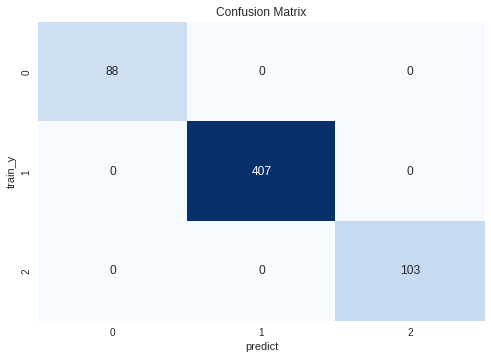

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(train_df["Y_Class"], train_preds["Label"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("train_y")
plt.xlabel("predict")
plt.show()

In [52]:
submit = pd.read_csv('/content/drive/MyDrive/datasets/aimers/sample_submission.csv')

In [65]:
preds = preds.reset_index()
preds

,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2875,Label,Score
0,2022-09-09 02:01:00,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.8819
1,2022-09-09 02:09:00,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.7979
2,2022-09-09 08:42:00,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.9065
3,2022-09-09 10:56:00,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,423.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.7048
4,2022-09-09 11:04:00,T010306,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,423.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.5685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,2022-11-05 11:18:00,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.9176
306,2022-11-05 16:39:00,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.8937
307,2022-11-05 16:47:00,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.9146
308,2022-11-05 20:53:00,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.9085


In [66]:
submit['Y_Class'] = preds["Label"]

In [67]:
submit

,PRODUCT_ID,Y_Class
0,TEST_000,1
1,TEST_001,1
2,TEST_002,1
3,TEST_003,1
4,TEST_004,1
...,...,...
305,TEST_305,1
306,TEST_306,1
307,TEST_307,1
308,TEST_308,1


In [68]:
submit.to_csv('/content/drive/MyDrive/datasets/aimers/pycaret_submission.csv', index=False)